In [196]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pymc3 as pm
import matplotlib.ticker as mtick


In [3]:
loc_data =  pd.read_csv("./location_data_hw9.csv")

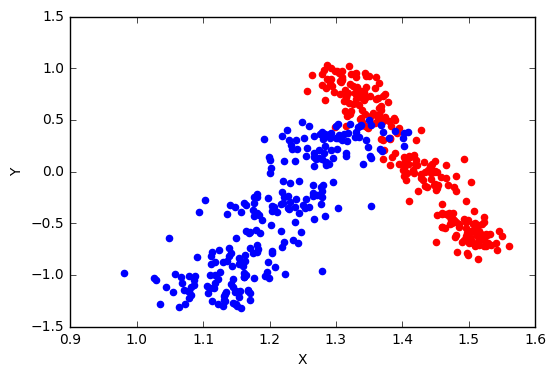

In [12]:
plt.scatter(loc_data['red_pos_X'], loc_data['red_pos_Y'], color = "r", marker = "o")
plt.scatter(loc_data['blue_pos_X'], loc_data['blue_pos_Y'], color = "b", marker = "o")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

We look at the plots as function of time

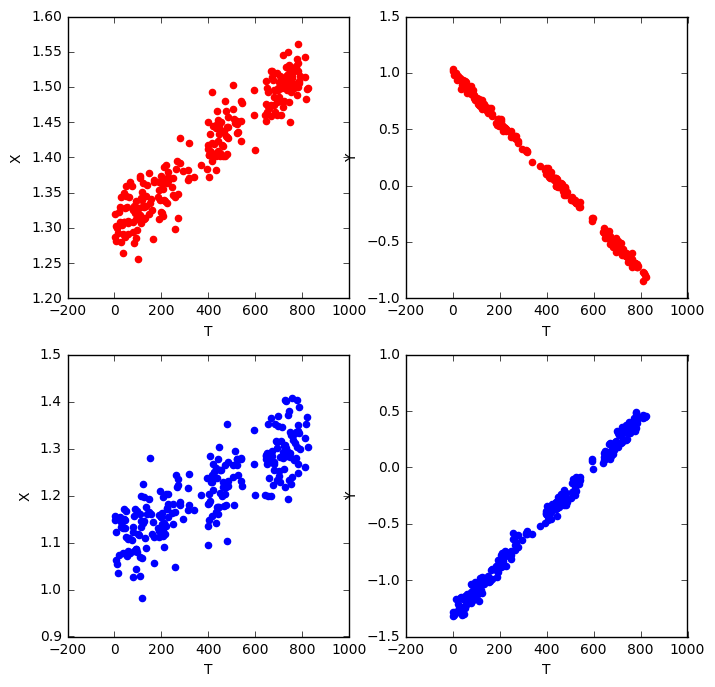

In [19]:
fig, axar = plt.subplots(2, 2, figsize = (8, 8))
axar[0, 0].scatter(loc_data["t"], loc_data["red_pos_X"], color = "r")
axar[0, 0].set_ylabel("X")
axar[0, 1].scatter(loc_data["t"], loc_data["red_pos_Y"], color = "r")
axar[0, 1].set_ylabel("Y")
axar[1, 0].scatter(loc_data["t"], loc_data["blue_pos_X"], color = "b")
axar[1, 0].set_ylabel("X")
axar[1, 1].scatter(loc_data["t"], loc_data["blue_pos_Y"], color = "b")
axar[1, 1].set_ylabel("Y")

for axis in axar:
    for axis2 in axis:
        axis2.set_xlabel("T")

### Strategy
The motion in **x & y direction is independent** of each other. Thus we essentially have to fit the model in each direction for each object independently (for the first part). <br>
**Noise: **The assumption here is that the noise is Gaussian in both the directions, which seems plausible from the plots against time above since it seems that the noise is more in x-direction than y-direction and hence should be different.<br>
**Free Parameters: ** starting position and velocity in each direction
**Speed** To get speed then, we can sample from the posteriors we have on the velocity in each direction. 
<br>
<br>
**NOTE:** We cannot exploit this independence for the part where both the objects have the same speed. Need to think how to include that constraint

In [27]:
mean_data = {}
for color in ["red", "blue"]:
    for direct in ["X", "Y"]:
        mean_data[color + direct + "0"] = loc_data[color + "_pos_" + direct][0]
        mean_data[color + "v" + direct + "0"] = \
        (loc_data[color + "_pos_" + direct][237] - loc_data[color + "_pos_" + direct][0])/(loc_data["t"][237] - loc_data["t"][0])

In [30]:
# with pm.Model() as model:
#     redvX = pm.Normal('redvX', mean_data['redvX0'], sd = 0.05)
#     redvY = pm.Normal('redvY', mean_data['redvY0'], sd = 0.05)
#     bluevX = pm.Normal('bluevX', mean_data['bluevX0'], sd = 0.05)
#     bluevY = pm.Normal('bluevY', mean_data['bluevY0'], sd = 0.05)
#     redX = pm.Normal('redX', mean_data['redX0'], sd = 0.05)
#     redY = pm.Normal('redY', mean_data['redY0'], sd = 0.05)
#     blueX = pm.Normal('blueX', mean_data['blueX0'], sd = 0.05)
#     blueY = pm.Normal('blueY', mean_data['blueY0'], sd = 0.05)


In [102]:
#Define a funciton to do mcmc for each direction and color
def domc(mean_pos, mean_vel, noise, obs_pos, time, color, direct):
    
    with pm.Model() as model:
        redvX = pm.Normal(color + '_v_' + direct, mean_vel, sd = noise)
#         redvX = pm.Uniform(color + '_v_' + direct, 0, 3*mean_vel)
        redX = pm.Normal(color + "_" + direct + '0', mean_pos, sd = noise)

        #Expected position
        redXpos = redX + redvX*(time - time[0])

        #Likelihood
        redX_obs = pm.Normal(color + "_" + direct + "_obs", mu=redXpos, sd= noise, observed= obs_pos)

    N = int(1e5)
    burn_in_frac = 0.1
    thin_factor = 5

    with model:
        step = pm.Metropolis()
        trace = pm.sample(N, step=step, njobs=1)

    burned_in = trace[int(burn_in_frac * N):]
    samples = burned_in[::thin_factor]
    
    return trace

In [103]:
#Do the mcmc for each direction and color

#From plots above, it seems noise is different in each direction
noise_dict = dict(redX = 0.07, blueX = 0.1, redY = 0.02, blueY = 0.02)

traces = {}
for color in ["red", "blue"]:
    for direct in ["X", "Y"]:
        mean_pos = mean_data[color + direct + "0"]
        mean_vel = mean_data[color + "v"+ direct + "0"]
        obs_pos = loc_data[color + "_pos_" + direct]
        time = loc_data["t"]
        noise = noise_dict[color + direct]
        traces[color + direct] = domc(mean_pos, mean_vel, noise, obs_pos, time, color, direct)


100%|██████████| 100000/100000 [00:19<00:00, 5045.16it/s]


In [104]:
#Get samples from trace by removing burning and doing thinning
samples = {}
N = int(1e5)
burn_in_frac = 0.1
thin_factor = 5
for color in ["red", "blue"]:
    for direct in ["X", "Y"]:
        samples[color + direct] = (traces[color + direct][int(burn_in_frac * N):])[::thin_factor]


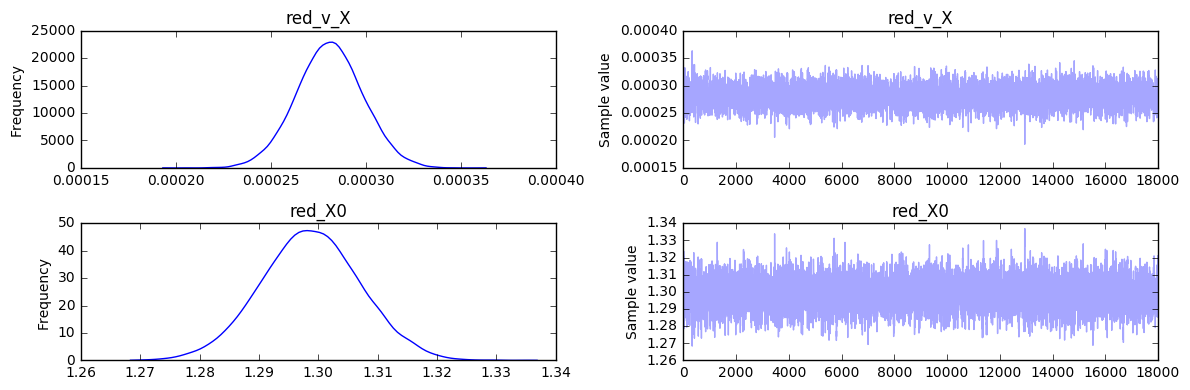

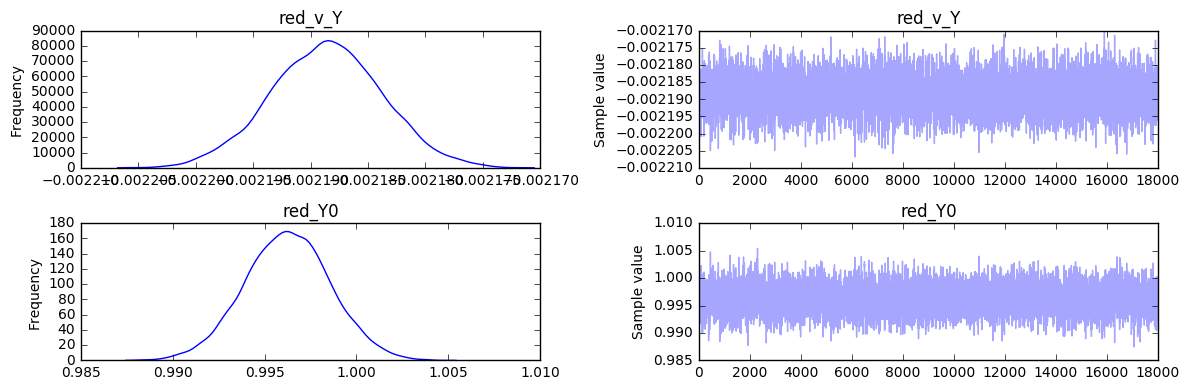

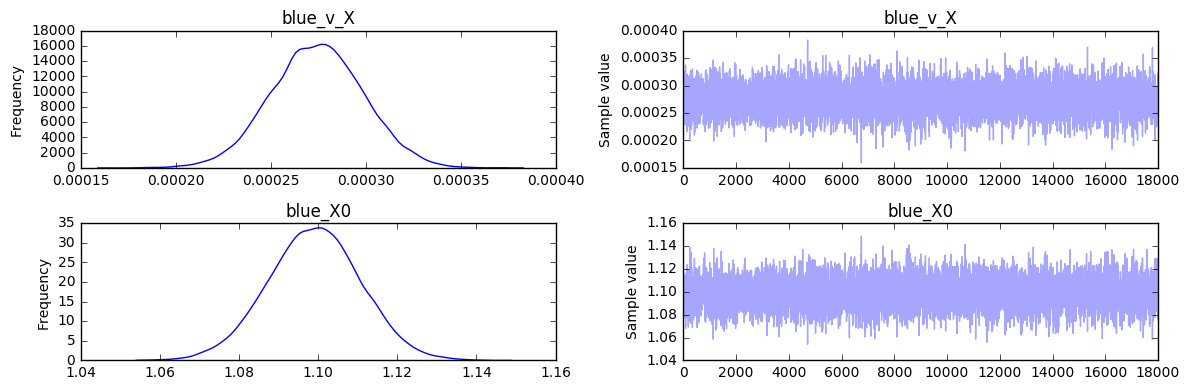

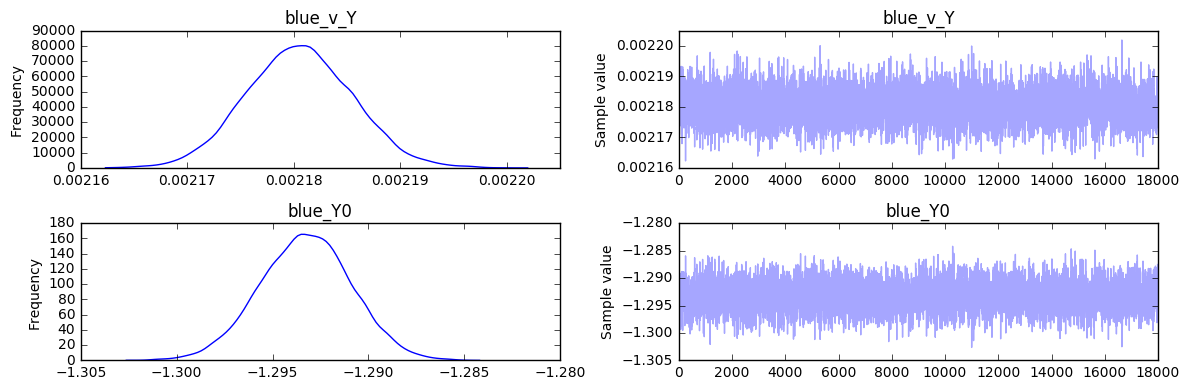

In [105]:
for color in ["red", "blue"]:
    for direct in ["X", "Y"]:
        pm.traceplot(samples[color + direct])
        plt.show()

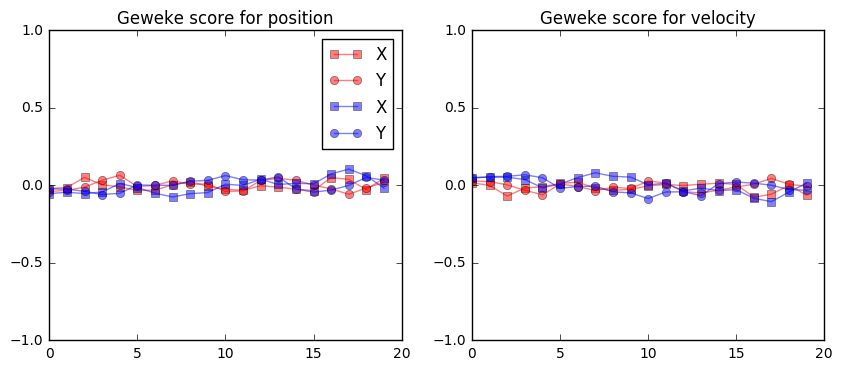

In [197]:
#To check is chains have convereged

fig, axar = plt.subplots(1, 2, figsize = (10, 4))

ax= axar[0]
for color in ["red", "blue"]:
    for direct in ["X", "Y"]:
        if direct == 'Y':
            marker = "o"
        else: marker = 's'
        ax.plot(pm.geweke(samples[color + direct][color + "_" + direct + '0'])[:, 1], \
                   marker = marker, color = color, alpha = 0.5, label = direct)
ax.legend()
ax.set_ylim(-1, 1)
ax.set_title("Geweke score for position")

ax= axar[1]
for color in ["red", "blue"]:
    for direct in ["X", "Y"]:
        if direct == 'Y':
            marker = "o"
        else: marker = 's'
        ax.plot(pm.geweke(samples[color + direct][color + "_v_" + direct ])[:, 1], \
                   marker = marker, color = color, alpha = 0.5)
ax.set_ylim(-1, 1)
ax.set_title("Geweke score for velocity")
plt.show()

Verify that result makes sense. We overplot the scatterplot of the data with a straight-line motion corresponding to the mean starting position and the velocity we have estimated above.

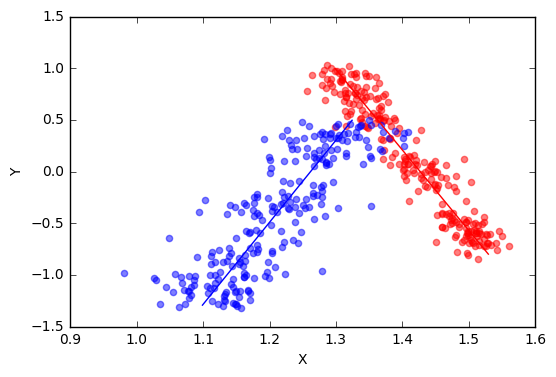

In [126]:
plt.scatter(loc_data['red_pos_X'], loc_data['red_pos_Y'], color = "r", marker = "o", alpha = 0.5)
plt.scatter(loc_data['blue_pos_X'], loc_data['blue_pos_Y'], color = "b", marker = "o", alpha = 0.5)
for color in ["red", "blue"]:
    vx = samples[color + "X"][color + "_v_X"].mean()
    vy = samples[color + "Y"][color + "_v_Y"].mean()
    x0 = samples[color + "X"][color + "_X0"].mean()
    y0 = samples[color + "Y"][color + "_Y0"].mean()
    plt.plot(x0 + vx*(loc_data['t'] - loc_data['t'][0]), y0 + vy*(loc_data['t'] - loc_data['t'][0]), color = color)

plt.xlabel("X")
plt.ylabel("Y")
plt.show()


To get a posterior on the speed, we simply sample from the gaussian of the speeds in the independent directions we have estimated

In [136]:
#Posterior of speed

def mcmc_speed(vx, vy, color):
    with pm.Model() as model_speed:
        redvX = pm.Normal(color +"vX" , vx.mean(), sd = vx.std())
        redvY = pm.Normal(color +"vY", vy.mean(), sd = vy.std())
        
        #Expected position
        speed = pm.Deterministic("speed", (redvX**2 + redvY**2)**0.5)

#         Likelihood
#         redX_obs = pm.Normal(color + "_" + direct + "_obs", mu=redXpos, sd= noise, observed= obs_pos)

    N = int(1e5)
    with model_speed:
        step = pm.Metropolis()
        trace = pm.sample(N, step=step, njobs=1)

    return trace


speeds = {}
for color in ["red", "blue"]:
    vx = samples[color + "X"][color + "_v_X"]
    vy = samples[color + "Y"][color + "_v_Y"]
    speeds[color] = mcmc_speed(vx, vy, color)

100%|██████████| 100000/100000 [00:15<00:00, 6419.97it/s]


In [137]:
#Get samples from trace by removing burning and doing thinning
speedsamples = {}
N = int(1e5)
burn_in_frac = 0.1
thin_factor = 5
for color in ["red", "blue"]:
    speedsamples[color] = (speeds[color][int(burn_in_frac * N):])[::thin_factor]


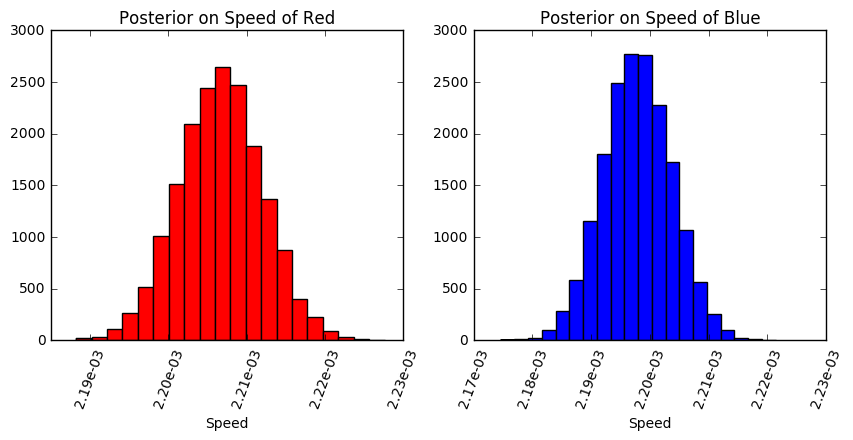

In [195]:
#Posterior plot on speed

fig, axar = plt.subplots(1, 2, figsize = (10, 4))
ax = axar[0]
ax.hist(speedsamples['red']['speed'], bins = 20, color = "red")
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
loc = ax.get_xticks()
labels = ax.get_xticklabels()
ax.set_xticks(loc[1::2])
for tick in ax.get_xticklabels():
        tick.set_rotation(70)
ax.set_title("Posterior on Speed of Red")
ax.set_xlabel("Speed")

ax = axar[1]
ax.hist(speedsamples['blue']['speed'], bins = 20, color = "blue")
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
for tick in ax.get_xticklabels():
        tick.set_rotation(70)
ax.set_title("Posterior on Speed of Blue")
ax.set_xlabel("Speed")
plt.show()

### Summary Statistics

In [251]:
for color in ["red", "blue"]:
    vx = samples[color + "X"][color + "_v_X"].mean()
    vxer = samples[color + "X"][color + "_v_X"].std()
    vy = samples[color + "Y"][color + "_v_Y"].mean()
    vyer = samples[color + "Y"][color + "_v_Y"].std()
    x0 = samples[color + "X"][color + "_X0"].mean()
    x0er = samples[color + "X"][color + "_X0"].std()
    y0 = samples[color + "Y"][color + "_Y0"].mean()
    y0er = samples[color + "Y"][color + "_Y0"].std()
    speed = speedsamples[color]["speed"].mean()
    speeder = speedsamples[color]["speed"].std()
    
    print("For object %s, starting position is (%0.3f, %0.3f) and velocity is (%0.3e, %0.3e) resulting in speed = %0.4e"%(color, x0, y0, vx, vy, speed))

For object red, starting position is (1.299, 0.996) and velocity is (2.811e-04, -2.189e-03) resulting in speed = 2.2067e-03
For object blue, starting position is (1.099, -1.293) and velocity is (2.745e-04, 2.181e-03) resulting in speed = 2.1978e-03


#### Quantiles
To get quantiles, we note that to cross 0, we simply need to divide the starting **y position** with **y velocity** and add the starting time to it.<br>
So we use the pm.quantiles with the samples given as starting position/velocity

In [237]:
redcross = pm.quantiles(traces['redY']['red_Y0']/abs(traces['redY']['red_v_Y']), [5, 50, 95])
bluecross = pm.quantiles(abs(traces['blueY']['blue_Y0'])/abs(traces['blueY']['blue_v_Y']), [5, 50, 95])
print("Quantiles for Red (from T = T0) are ", redcross)
print("Quantiles for Blue (from T = T0) are ", bluecross)


Quantiles for Red (from T = T0) are  {50: 455.19198380950405, 5: 454.19659513091869, 95: 456.19437967552994}
Quantiles for Blue (from T = T0) are  {50: 593.10687796393563, 5: 591.86873144926903, 95: 594.33404700633298}


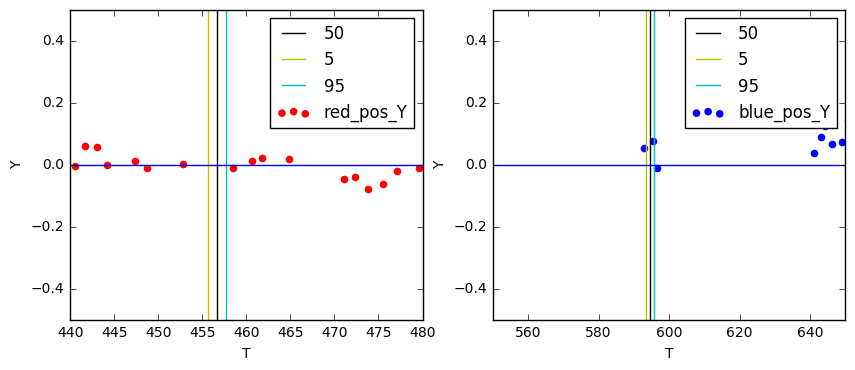

In [241]:
cscheme = ["k", "y", "c"]
fig, axar = plt.subplots(1, 2, figsize = (10, 4))
ax = axar[0]
ax.scatter(loc_data["t"], loc_data["red_pos_Y"], color = "r")
ax.set_ylabel("Y")
counter = 0 
for foo in redcross:
    ax.axvline(redcross[foo] + loc_data['t'][0], label = foo, color = cscheme[counter])
    counter +=1 
ax.legend(loc = 0, fontsize = 12)
ax.set_xlim(440, 480)
ax.set_ylim(-0.5, 0.5)

ax = axar[1]
ax.scatter(loc_data["t"], loc_data["blue_pos_Y"], color = "b")
ax.set_ylabel("Y")
counter = 0 
for foo in bluecross:
    ax.axvline(bluecross[foo] + loc_data['t'][0], label = foo, color = cscheme[counter])
    counter +=1 
ax.legend(loc = 0, fontsize = 12)
ax.set_xlim(550, 650)
ax.set_ylim(-0.5, 0.5)

for axis in axar:
    axis.set_xlabel("T")
    axis.axhline(0)

### Constraints
For including the information that the objects have same speed, we will need to use some constraints but I am short on time to figure out how to do that.

### 100 instead of 237

This is the same method as above